In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option("display.max_columns", 99)
df = pd.read_csv("../data/mergeB_for_modeling.csv")
df.head(n=3)


,Year,STNAM,FIPST,LEAID,LEANM,NCESSCH,SCHNAM,ALL_COHORT_,school_name,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part,ALL_RATE_,area_name,rural_urban_continuum_code,urban_influence_code,metro_or_not,civilian_labor_force,unemployment_rate
0,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100208,Bethel Regional High School,75,BETHEL REGIONAL HIGH SCHOOL,99559.0,99559.0,60.802584,41.0,2050.0,4.0,1.0,6.0,12.0,5.0,1.0,0.0,0.0,0.0,32.849998,210.0,28.0,238.0,506.0,0.0,97.5,97.5,52.0,"Bethel Census Area, AK",7.0,11.0,0.0,7193.0,15.6
1,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100318,Bethel Alternative Boarding School,28,BETHEL ALTERNATIVE BOARDING SCHOOL,99559.0,99559.0,60.795960,33.0,2050.0,3.0,4.0,8.0,12.0,5.0,1.0,0.0,0.0,0.0,4.000000,58.0,0.0,58.0,61.0,0.0,90.0,90.0,10.0,"Bethel Census Area, AK",7.0,11.0,0.0,7193.0,15.6
2,2012,ALASKA,2,200006,Mount Edgecumbe High School Agency,20000600558,Mt. Edgecumbe High School,71,MT. EDGECUMBE HIGH SCHOOL,99835.0,99835.0,57.051810,41.0,2220.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,22.500000,224.0,35.0,259.0,398.0,0.0,97.5,97.5,97.5,"Sitka Borough/city, AK",7.0,11.0,0.0,4627.0,5.7


# New Feature Creation

In [3]:
# Create features by dividing one column by another or subtracting one column from another.

df["teacher_ratio1"] = df.teachers_fte / df.enrollment
df["teacher_ratio2"] = df.teachers_fte / df.ALL_COHORT_
df["num_grades"] = df.highest_grade_offered - df.lowest_grade_offered


In [4]:
# Subset to features that we believe have unique information in them; e.g. removing ID columns, names as strings.
# Categoricals like FIPST, LEAID, zip_location, and county_code like have some useful information but may have too many categories (1000s)
# to dummy encode. Also we do not want to have our model score schools based on what code or state they are in.

X = df.copy()

X.drop(
    [
        "STNAM",
        "LEANM",
        "NCESSCH",
        "SCHNAM",
        "school_name",
        "zip_mailing",
        "LEAID",
        "zip_location",
        "county_code",
        "FIPST",
        "area_name",
        "Year",
    ],
    inplace=True,
    axis=1,
)


y = X.pop("ALL_RATE_")

# Tag categoricals so that they can be treated properly by the modeling packages
numeric_cols = [
    "Rla_Pct_Part",
    "Math_Pct_Part",
    "enrollment",
    "free_lunch",
    "reduced_price_lunch",
    "free_or_reduced_price_lunch",
    "teachers_fte",
    "lowest_grade_offered",
    "highest_grade_offered",
    "latitude",
    "ALL_COHORT_",
    "civilian_labor_force",
    "unemployment_rate",
    "teacher_ratio1",
    "teacher_ratio2",
    "num_grades",
]

for col in numeric_cols:
    assert col in X.columns
categoricals = list(set(X.columns.tolist()) - set(numeric_cols))

# Convert categoricals to the pandas type 'category'
for col in categoricals:
    X[col] = X[col].astype("category")

pd.set_option("display.max_rows", 999)
X.dtypes


ALL_COHORT_                       int64
latitude                        float64
urban_centric_locale           category
school_level                   category
school_type                    category
lowest_grade_offered            float64
highest_grade_offered           float64
title_i_status                 category
title_i_eligible               category
charter                        category
magnet                         category
virtual                        category
teachers_fte                    float64
free_lunch                      float64
reduced_price_lunch             float64
free_or_reduced_price_lunch     float64
enrollment                      float64
ungrade_cedp                   category
Math_Pct_Part                   float64
Rla_Pct_Part                    float64
rural_urban_continuum_code     category
urban_influence_code           category
metro_or_not                   category
civilian_labor_force            float64
unemployment_rate               float64


In [5]:
# Create train-test split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)


In [6]:
Xtrain.head(n=2)


,ALL_COHORT_,latitude,urban_centric_locale,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part,rural_urban_continuum_code,urban_influence_code,metro_or_not,civilian_labor_force,unemployment_rate,teacher_ratio1,teacher_ratio2,num_grades
28263,18,39.80761,43.0,3.0,1.0,7.0,12.0,1.0,1.0,0.0,0.0,0.0,18.000000,58.0,21.0,79.0,146.0,0.0,90.0,90.0,9.0,12.0,0.0,1518.0,2.4,0.123288,1.00000,5.0
12172,40,35.35770,42.0,3.0,1.0,7.0,12.0,5.0,1.0,0.0,0.0,0.0,32.709999,130.0,49.0,179.0,277.0,0.0,97.5,95.0,4.0,5.0,0.0,35304.0,7.6,0.118087,0.81775,5.0


# Optimize RandomForest and get Feature Importance

In [7]:
# Create and run hyperparameter tuning pipeline
from sklearn.model_selection import GridSearchCV
import warnings
import joblib
import os

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
param_grid = {
    "rf__n_estimators": [500],
    "rf__max_features": [55,60,65],
    "rf__max_depth": [90, 100],
    "rf__ccp_alpha": [0.0],
    "rf__random_state": [42],
}
pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),
        ("rf", RandomForestRegressor()),
    ]
)

# Load model from disk instead of running again.
clf = {}
local_model_path = (
    "../../student_outcome_saved_models/model_datasetB_random_forest_gridsearch2.pkl"
)
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe,
        param_grid,
        n_jobs=4,
        verbose=3,
        cv=4,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)


In [8]:
# Print out best parameters
print(clf.best_params_)
clf.cv_results_
del clf
# Best param first round of GridSearch
# {'rf__ccp_alpha': 0.0, 'rf__max_depth': 100, 'rf__max_features': 60, 'rf__n_estimators': 500, 'rf__random_state': 42}
# Best param second round of GridSearch
# {'rf__ccp_alpha': 0.0, 'rf__max_depth': 90, 'rf__max_features': 55, 'rf__n_estimators': 500, 'rf__random_state': 42}

{'rf__ccp_alpha': 0.0, 'rf__max_depth': 90, 'rf__max_features': 55, 'rf__n_estimators': 500, 'rf__random_state': 42}


# Check best parameters on the test set

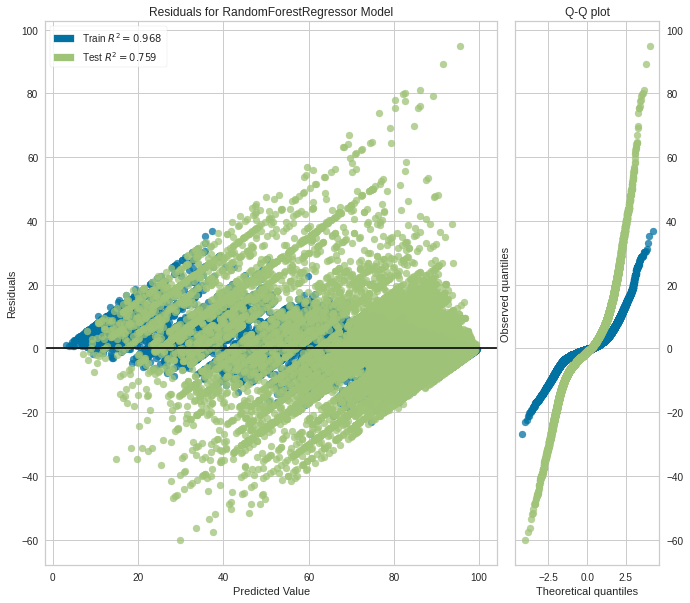

train rmsd =  3.4860088796231845
test rmsd =  9.543615669463891


In [9]:
# Validate the best model on the train and test sets
# The fact that our residuals are far from normal suggests that we could improve our model.

from sklearn.metrics import r2_score

scaler = SklearnTransformerWrapper(transformer=StandardScaler(), variables=categoricals+numeric_cols)

pipe2 = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),
        (
            "rf",
            RandomForestRegressor(
                n_jobs=2,
                max_features=55,
                n_estimators=500,
                max_depth=90,
                random_state=42,
            ),
        ),
    ]
)
pipe2.fit(Xtrain, ytrain)
plt.rcParams["figure.figsize"] = (11, 10)
residuals_plot(pipe2, Xtrain, ytrain, Xtest, ytest, hist=False, qqplot=True)
plt.show()

train_residuals = pipe2.predict(Xtrain) - ytrain
test_residuals = pipe2.predict(Xtest) - ytest

print("train rmsd = ", train_residuals.describe()[2])
print("test rmsd = ", test_residuals.describe()[2])


# Feature importance from RandomForest 


/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Top 60')

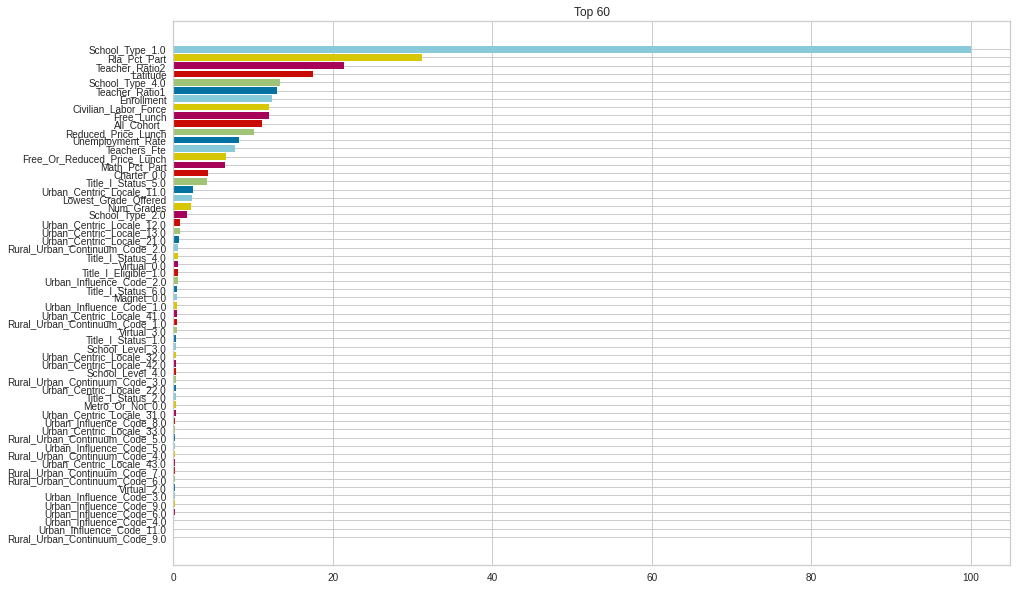

In [10]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
# Title case the feature for better display and create the visualizer
onehotter = OneHotEncoder(drop_last=True,variables=categoricals)
Xtrain_transformed = onehotter.fit_transform(Xtrain) 
labels = list(map(lambda s: s.title(), Xtrain_transformed.columns.tolist()))
viz_rf = FeatureImportances(pipe2._final_estimator, labels=labels, relative=True,size=(1080,720),topn=60)
# Fit and show the feature importances
viz_rf.fit(Xtrain, ytrain)
viz_rf.fig.savefig("../figures/RandomForest_Feature_Importances_DatasetB.png")
plt.title(viz_rf._get_topn_title())

# Feature importance from polynomial features and lasso

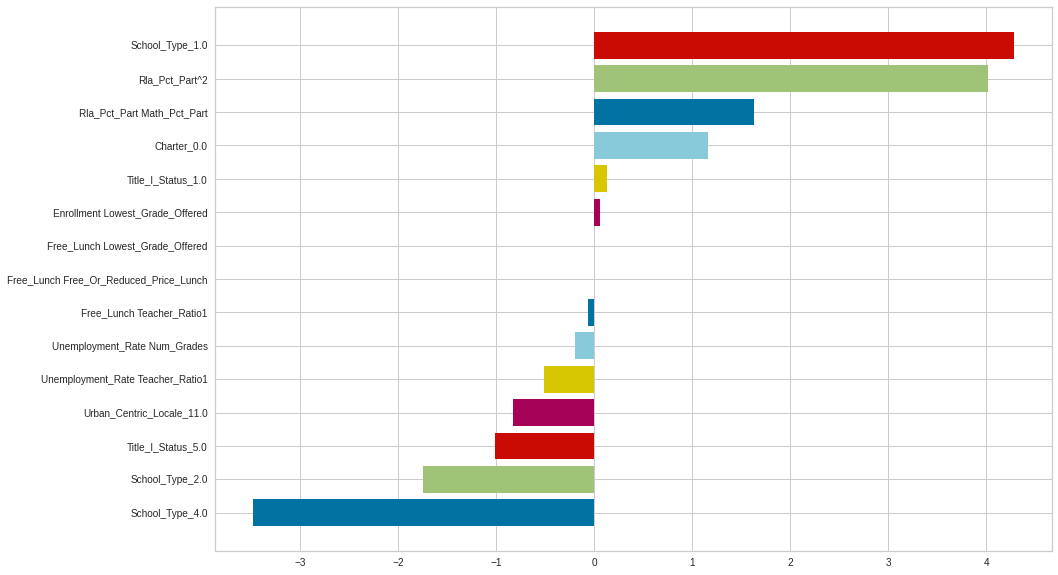

In [11]:
# OneHot, Polynomial the numeric features, scale numeric features.
# Lasso to reduce features 
from sklearn.pipeline import Pipeline
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

"""
df2 = df.copy() 

df2.drop(
    [
        "STNAM",
        "LEANM",
        "NCESSCH",
        "SCHNAM",
        "school_name",
        "zip_mailing",
        "LEAID",
        "zip_location",
        "county_code",
        "FIPST",
        "area_name",
        "Year",
    ],
    inplace=True,
    axis=1,
)
y = df2.pop('ALL_RATE_')

# Tag categoricals so that they can be treated properly by the modeling packages
numeric_cols = [
    "Rla_Pct_Part",
    "Math_Pct_Part",
    "enrollment",
    "free_lunch",
    "reduced_price_lunch",
    "free_or_reduced_price_lunch",
    "teachers_fte",
    "lowest_grade_offered",
    "highest_grade_offered",
    "latitude",
    "ALL_COHORT_",
    "civilian_labor_force",
    "unemployment_rate",
    "teacher_ratio1",
    "teacher_ratio2",
    "num_grades",
]

for col in numeric_cols:
    assert col in df2.columns
categoricals = list(set(df2.columns.tolist()) - set(numeric_cols))

# Convert categoricals to the pandas type 'category'
for col in categoricals:
    df2[col] = df2[col].astype("category")
"""
polynomial = SklearnTransformerWrapper(transformer=PolynomialFeatures(degree=2), variables=numeric_cols)

df2_poly = polynomial.fit_transform(Xtrain)
df2_onehot = onehotter.fit_transform(df2_poly)
scaler = SklearnTransformerWrapper(transformer=StandardScaler(), variables=df2_onehot.select_dtypes(include=np.number).columns.tolist())
df2_scaled = scaler.fit_transform(df2_onehot)


# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), df2_scaled.columns.tolist()))
viz_lasso = FeatureImportances(Lasso(), labels=labels, relative=False,size=(1080,720),topn=15)
# Fit and show the feature importances
viz_lasso.fit(df2_scaled, ytrain)
viz_lasso.fig.savefig("Lasso_Feature_Importances_DatasetB.png")

# Reduce number of features
* Reduces modeling time
* Improves interpretability
* Prevents overfitting to create a more general model

In [12]:
# Combine top X features from RandomForest and Polynomial Lasso
df.columns = labels = list(map(lambda s: s.title(), df.columns.tolist()))

top_features_rf = list(dict(sorted(list(zip(viz_rf.feature_importances_,viz_rf.features_)),reverse=True)).values())
top_features_rf

features_to_drop = []
for col in df.columns:
    if col not in " ".join(top_features_rf):
        features_to_drop += [col]
features_to_drop.remove("All_Rate_")
features_to_drop.remove("Year")
features_to_drop.remove("Ncessch")
features_to_drop.remove("Schnam")
df.drop(features_to_drop,inplace=True,axis=1)
df.columns

Index(['Year', 'Ncessch', 'Schnam', 'All_Cohort_', 'Latitude',
       'Urban_Centric_Locale', 'School_Level', 'School_Type',
       'Lowest_Grade_Offered', 'Title_I_Status', 'Title_I_Eligible', 'Charter',
       'Magnet', 'Virtual', 'Teachers_Fte', 'Free_Lunch',
       'Reduced_Price_Lunch', 'Free_Or_Reduced_Price_Lunch', 'Enrollment',
       'Math_Pct_Part', 'Rla_Pct_Part', 'All_Rate_',
       'Rural_Urban_Continuum_Code', 'Urban_Influence_Code', 'Metro_Or_Not',
       'Civilian_Labor_Force', 'Unemployment_Rate', 'Teacher_Ratio1',
       'Teacher_Ratio2', 'Num_Grades'],
      dtype='object')

# Create new features discoverd by polynomial + lasso

In [13]:
df['Rla_Pct_Part^2'] = df.Rla_Pct_Part * df.Rla_Pct_Part
df['Rla_Pct_Part Math_Pct_Part'] = df.Rla_Pct_Part * df.Math_Pct_Part
df['Free_Lunch_Teacher_Ratio1'] = df.Free_Lunch * df.Teacher_Ratio1
df['Unemployment_Rate_Num_Grades'] = df.Unemployment_Rate * df.Num_Grades
df['Unemployment_Rate_Teacher_Ratio1'] = df.Unemployment_Rate * df.Teacher_Ratio1

# Re-run Model On Reduced Feature Set

In [14]:
X = df.copy()
y = X.pop('All_Rate_')
X.drop(["Year","Ncessch","Schnam"],axis=1,inplace=True)

X.dtypes

All_Cohort_                           int64
Latitude                            float64
Urban_Centric_Locale                float64
School_Level                        float64
School_Type                         float64
Lowest_Grade_Offered                float64
Title_I_Status                      float64
Title_I_Eligible                    float64
Charter                             float64
Magnet                              float64
Virtual                             float64
Teachers_Fte                        float64
Free_Lunch                          float64
Reduced_Price_Lunch                 float64
Free_Or_Reduced_Price_Lunch         float64
Enrollment                          float64
Math_Pct_Part                       float64
Rla_Pct_Part                        float64
Rural_Urban_Continuum_Code          float64
Urban_Influence_Code                float64
Metro_Or_Not                        float64
Civilian_Labor_Force                float64
Unemployment_Rate               

In [16]:
# Revise numeric_cols and categoricals lists to be title case and include the new variables we created

numeric_cols = ["All_Cohort_", "Latitude", "Lowest_Grade_Offered", "Teachers_Fte", "Free_Lunch", "Reduced_Price_Lunch", "Free_Or_Reduced_Price_Lunch", "Enrollment", "Math_Pct_Part", "Rla_Pct_Part", "Civilian_Labor_Force", "Unemployment_Rate", "Teacher_Ratio1", "Teacher_Ratio2","Num_Grades","Rla_Pct_Part^2","Rla_Pct_Part Math_Pct_Part","Free_Lunch_Teacher_Ratio1","Unemployment_Rate_Num_Grades","Unemployment_Rate_Teacher_Ratio1"]

for col in numeric_cols:
    assert col in X.columns
categoricals = list(set(X.columns.tolist()) - set(numeric_cols))

# Convert categoricals to the pandas type 'category'
for col in categoricals:
    X[col] = X[col].astype("category")

# Create train-test split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)


In [17]:
categoricals

['Title_I_Eligible',
 'Charter',
 'Rural_Urban_Continuum_Code',
 'School_Type',
 'Virtual',
 'Urban_Influence_Code',
 'School_Level',
 'Urban_Centric_Locale',
 'Magnet',
 'Title_I_Status',
 'Metro_Or_Not']

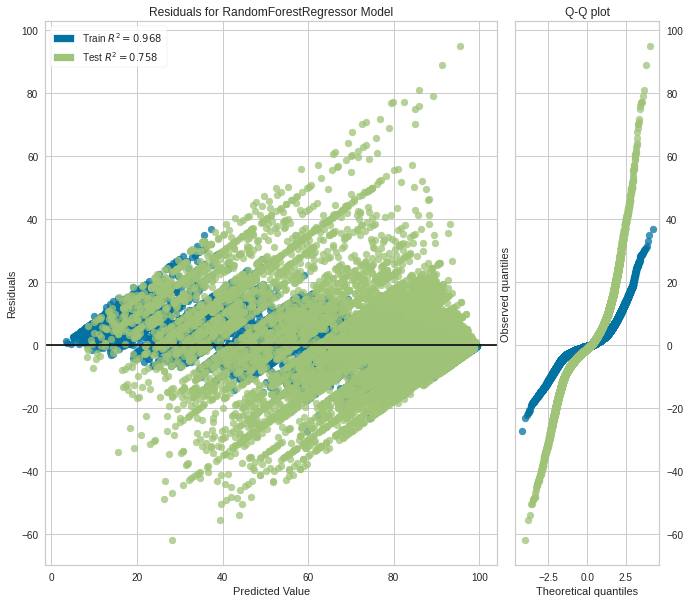

train rmsd =  3.5000684473321564
test rmsd =  9.557749482295957


In [19]:

from sklearn.metrics import r2_score

scaler = SklearnTransformerWrapper(transformer=StandardScaler(), variables=X.select_dtypes(include=np.number).columns.tolist())

pipe3 = Pipeline(
    steps=[
        ("scaler", scaler), ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),
        (
            "rf",
            RandomForestRegressor(
                n_jobs=5,
                max_features=45,
                n_estimators=500,
                max_depth=100,
                random_state=42,
            ),
        ),
    ]
)
pipe3.fit(Xtrain, ytrain)
plt.rcParams["figure.figsize"] = (11, 10)
residuals_plot(pipe3, Xtrain, ytrain, Xtest, ytest, hist=False, qqplot=True)
plt.show()

train_residuals = pipe3.predict(Xtrain) - ytrain
test_residuals = pipe3.predict(Xtest) - ytest

print("train rmsd = ", train_residuals.describe()[2])
print("test rmsd = ", test_residuals.describe()[2])

In [20]:
X

,All_Cohort_,Latitude,Urban_Centric_Locale,School_Level,School_Type,Lowest_Grade_Offered,Title_I_Status,Title_I_Eligible,Charter,Magnet,Virtual,Teachers_Fte,Free_Lunch,Reduced_Price_Lunch,Free_Or_Reduced_Price_Lunch,Enrollment,Math_Pct_Part,Rla_Pct_Part,Rural_Urban_Continuum_Code,Urban_Influence_Code,Metro_Or_Not,Civilian_Labor_Force,Unemployment_Rate,Teacher_Ratio1,Teacher_Ratio2,Num_Grades,Rla_Pct_Part^2,Rla_Pct_Part Math_Pct_Part,Free_Lunch_Teacher_Ratio1,Unemployment_Rate_Num_Grades,Unemployment_Rate_Teacher_Ratio1
0,75,60.802584,41.0,4.0,1.0,6.0,5.0,1.0,0.0,0.0,0.0,32.849998,210.0,28.0,238.0,506.0,97.5,97.5,7.0,11.0,0.0,7193.0,15.6,0.064921,0.438000,6.0,9506.25,9506.25,13.633399,93.6,1.012767
1,28,60.795960,33.0,3.0,4.0,8.0,5.0,1.0,0.0,0.0,0.0,4.000000,58.0,0.0,58.0,61.0,90.0,90.0,7.0,11.0,0.0,7193.0,15.6,0.065574,0.142857,4.0,8100.00,8100.00,3.803279,62.4,1.022951
2,71,57.051810,41.0,3.0,1.0,9.0,5.0,1.0,0.0,0.0,0.0,22.500000,224.0,35.0,259.0,398.0,97.5,97.5,7.0,11.0,0.0,4627.0,5.7,0.056533,0.316901,3.0,9506.25,9506.25,12.663317,17.1,0.322236
3,17,58.733307,43.0,3.0,1.0,7.0,3.0,1.0,0.0,0.0,0.0,7.620000,29.0,4.0,33.0,76.0,90.0,90.0,9.0,12.0,0.0,479.0,10.0,0.100263,0.448235,5.0,8100.00,8100.00,2.907632,50.0,1.002632
4,24,60.540506,43.0,3.0,1.0,7.0,3.0,1.0,0.0,0.0,0.0,11.150000,57.0,18.0,75.0,152.0,95.0,95.0,9.0,11.0,0.0,4877.0,9.8,0.073355,0.464583,5.0,9025.00,9025.00,4.181250,49.0,0.718882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83653,186,41.501919,33.0,3.0,1.0,9.0,6.0,0.0,0.0,0.0,0.0,46.279999,110.0,76.0,186.0,750.0,99.5,99.5,5.0,8.0,0.0,21383.0,4.2,0.061707,0.248817,3.0,9900.25,9900.25,6.787733,12.6,0.259168
83654,163,43.457147,41.0,3.0,1.0,9.0,6.0,0.0,0.0,0.0,0.0,52.020000,83.0,49.0,132.0,720.0,99.5,99.5,7.0,8.0,0.0,15467.0,3.0,0.072250,0.319141,3.0,9900.25,9900.25,5.996750,9.0,0.216750
83655,20,43.460060,33.0,3.0,1.0,9.0,6.0,0.0,0.0,0.0,0.0,6.500000,16.0,4.0,20.0,49.0,90.0,90.0,7.0,8.0,0.0,15467.0,3.0,0.132653,0.325000,3.0,8100.00,8100.00,2.122449,9.0,0.397959
83656,25,44.097024,43.0,3.0,1.0,9.0,6.0,0.0,0.0,0.0,0.0,12.600000,18.0,11.0,29.0,70.0,95.0,95.0,7.0,9.0,0.0,3786.0,3.5,0.180000,0.504000,3.0,9025.00,9025.00,3.240000,10.5,0.630000


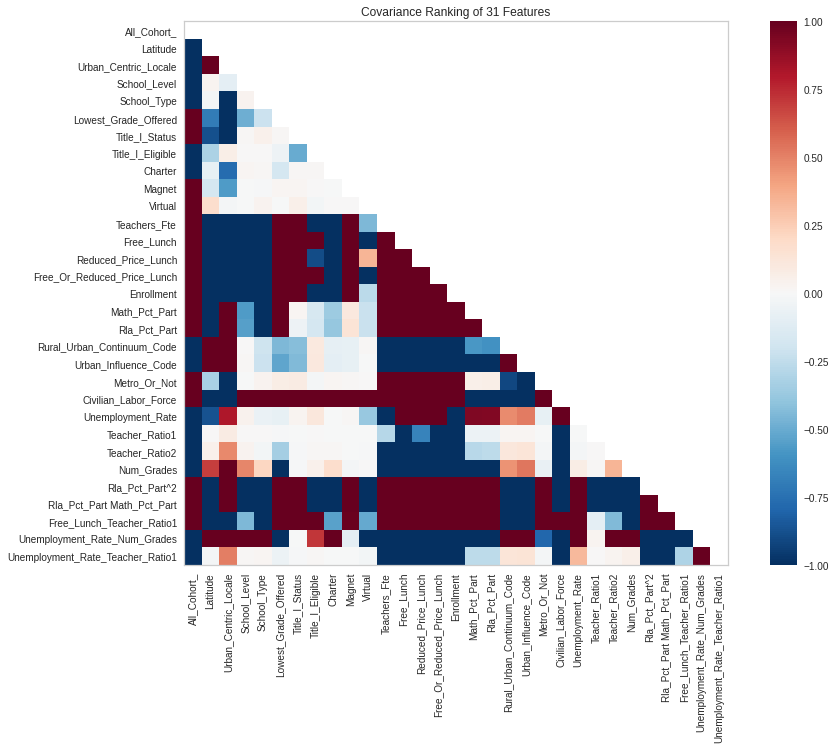

<AxesSubplot:title={'center':'Covariance Ranking of 31 Features'}>

In [21]:
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates
visualizer = Rank2D(algorithm='covariance', features=(X).columns.tolist(), size=(1080, 720))
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

In [27]:
Xtrain.head()

,All_Cohort_,Latitude,Urban_Centric_Locale,School_Level,School_Type,Lowest_Grade_Offered,Title_I_Status,Title_I_Eligible,Charter,Magnet,Virtual,Teachers_Fte,Free_Lunch,Reduced_Price_Lunch,Free_Or_Reduced_Price_Lunch,Enrollment,Math_Pct_Part,Rla_Pct_Part,Rural_Urban_Continuum_Code,Urban_Influence_Code,Metro_Or_Not,Civilian_Labor_Force,Unemployment_Rate,Teacher_Ratio1,Teacher_Ratio2,Num_Grades,Rla_Pct_Part^2,Rla_Pct_Part Math_Pct_Part,Free_Lunch_Teacher_Ratio1,Unemployment_Rate_Num_Grades,Unemployment_Rate_Teacher_Ratio1
28263,18,39.807610,43.0,3.0,1.0,7.0,1.0,1.0,0.0,0.0,0.0,18.000000,58.0,21.0,79.0,146.0,90.0,90.0,9.0,12.0,0.0,1518.0,2.4,0.123288,1.000000,5.0,8100.00,8100.00,7.150685,12.0,0.295890
12172,40,35.357700,42.0,3.0,1.0,7.0,5.0,1.0,0.0,0.0,0.0,32.709999,130.0,49.0,179.0,277.0,97.5,95.0,4.0,5.0,0.0,35304.0,7.6,0.118087,0.817750,5.0,9025.00,9262.50,15.351263,38.0,0.897458
18366,40,40.472100,43.0,3.0,1.0,7.0,4.0,1.0,0.0,0.0,0.0,24.700001,101.0,44.0,145.0,270.0,95.0,95.0,9.0,10.0,0.0,2368.0,5.4,0.091481,0.617500,5.0,9025.00,9025.00,9.239630,27.0,0.494000
6980,58,36.502930,42.0,3.0,1.0,9.0,4.0,1.0,0.0,0.0,0.0,17.580000,84.0,24.0,108.0,216.0,95.0,97.5,6.0,5.0,0.0,13618.0,11.5,0.081389,0.303103,3.0,9506.25,9262.50,6.836667,34.5,0.935972
51783,75,40.724238,11.0,4.0,1.0,6.0,6.0,0.0,0.0,0.0,0.0,42.840000,285.0,72.0,357.0,574.0,97.5,97.5,1.0,1.0,1.0,1150751.0,4.5,0.074634,0.571200,6.0,9506.25,9506.25,21.270732,27.0,0.335854


In [43]:
features = ['Rla_Pct_Part Math_Pct_Part', 'School_Type','Urban_Centric_Locale','Rla_Pct_Part^2','Charter','Title_I_Status']
Xtrain[features]

,Rla_Pct_Part Math_Pct_Part,School_Type,Urban_Centric_Locale,Rla_Pct_Part^2,Charter,Title_I_Status
28263,8100.00,1.0,43.0,8100.00,0.0,1.0
12172,9262.50,1.0,42.0,9025.00,0.0,5.0
18366,9025.00,1.0,43.0,9025.00,0.0,4.0
6980,9262.50,1.0,42.0,9506.25,0.0,4.0
51783,9506.25,1.0,11.0,9506.25,0.0,6.0
...,...,...,...,...,...,...
21335,9506.25,1.0,32.0,9506.25,0.0,5.0
38697,5625.00,1.0,42.0,5625.00,1.0,5.0
50281,8970.00,1.0,41.0,9506.25,0.0,5.0
9684,9900.25,1.0,42.0,9900.25,0.0,5.0


In [44]:
np.percentile(ytrain,[0,25,50,75,100])

array([ 0.5, 79. , 90. , 95. , 99.5])

# Split our target variable (0-100%) into 25% chunks 

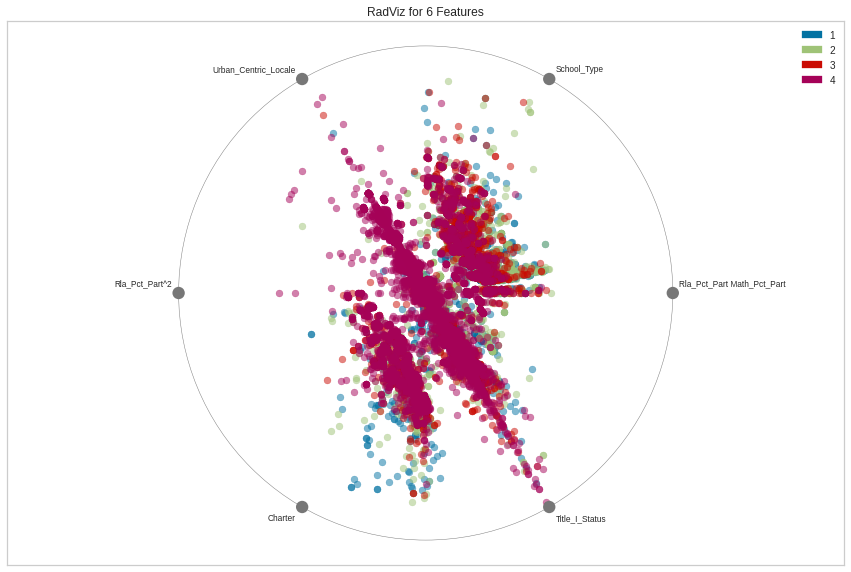

<AxesSubplot:title={'center':'RadViz for 6 Features'}>

In [47]:
# ytrain2 = np.digitize(ytrain,bins=np.percentile(ytrain,[0,25,50,75,100]))
ytrain2 = np.digitize(ytrain,bins=[0,25,50,75,100])
visualizer = RadViz(classes=None,alpha=0.5, features=features, size=(1080, 720))
visualizer.fit(Xtrain[features], ytrain2)
visualizer.transform(Xtrain[features])
visualizer.show()

# Split target variable up using percentiles so that they have equal numbers in each class

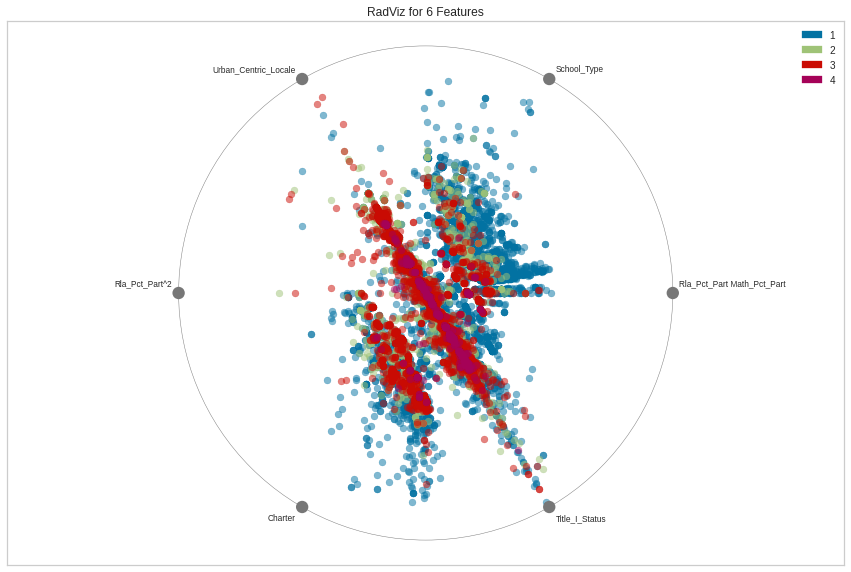

<AxesSubplot:title={'center':'RadViz for 6 Features'}>

In [70]:
# Split our target variable up into classes
grad_rate_classes = np.percentile(ytrain,[0,33,66,100])
ytrain_classes = np.digitize(ytrain,bins=grad_rate_classes)
ytest_classes = np.digitize(ytest,bins=grad_rate_classes)
visualizer = RadViz(classes=None,alpha=0.5, features=features, size=(1080, 720))
visualizer.fit(Xtrain[features], ytrain_classes)
visualizer.transform(Xtrain[features])
visualizer.show()

In [71]:
print(grad_rate_classes)
print(ytrain.describe())
print(pd.Series(ytrain_classes).value_counts())

[ 0.5 84.5 92.  99.5]
count    58560.000000
mean        82.567051
std         19.449057
min          0.500000
25%         79.000000
50%         90.000000
75%         95.000000
max         99.500000
Name: All_Rate_, dtype: float64
3    24317
1    19140
2    14357
4      746
dtype: int64


# Run A Random Forest Classification Model

In [72]:
df.to_csv("../data/mergeB_for_modeling_features_engineered.csv", index=False)

: 